In [23]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Praktikum9').getOrCreate()

data = [
    ('Darmawan', 19, 'M', 5000, 1),
    ('Musa', 19, 'M', 3600, 2),
    ('Sari', 21, 'F', 2300, 1),
    ('Desi', 21, 'F', 4200, 2)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+--------+---+------+------+------+
|    Name|Age|Gender|Salary|DeptId|
+--------+---+------+------+------+
|Darmawan| 19|     M|  5000|     1|
|    Musa| 19|     M|  3600|     2|
|    Sari| 21|     F|  2300|     1|
|    Desi| 21|     F|  4200|     2|
+--------+---+------+------+------+

+--------+---+
|    Name|Age|
+--------+---+
|Darmawan| 19|
|    Musa| 19|
|    Desi| 21|
+--------+---+

+-----------+
|avg(Salary)|
+-----------+
|     3775.0|
+-----------+



In [5]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       5000| 19|
|     M|       3600| 20|
|     F|       2300| 21|
+------+-----------+---+



In [6]:
spark.sql('''
SELECT DeptID, AVG(Salary) as avgSalary
FROM employees
GROUP BY DeptID
''').show()

+------+---------+
|DeptID|avgSalary|
+------+---------+
|     1|   3650.0|
|     2|   3600.0|
+------+---------+



In [7]:
spark.sql('''
WITH AvgSalaryByGender AS (
    SELECT Gender, AVG(Salary) as avgSalary
    FROM employees
    GROUP BY Gender
)
SELECT a.Name, a.Gender, a.Salary
FROM employees a
JOIN AvgSalaryByGender ags ON a.Gender = ags.Gender
WHERE a.Salary > ags.AvgSalary
''').show()

+--------+------+------+
|    Name|Gender|Salary|
+--------+------+------+
|Darmawan|     M|  5000|
+--------+------+------+



In [8]:
spark.sql('''
SELECT Name, Salary, DeptID,
       RANK() OVER (PARTITION BY DeptID ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

+--------+------+------+----------+
|    Name|Salary|DeptID|SalaryRank|
+--------+------+------+----------+
|Darmawan|  5000|     1|         1|
|    Sari|  2300|     1|         2|
|    Musa|  3600|     2|         1|
+--------+------+------+----------+



In [9]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+--------+---+------+----+
|    Name|Age|Salary|rank|
+--------+---+------+----+
|Darmawan| 19|  5000|   1|
|    Musa| 20|  3600|   1|
|    Sari| 21|  2300|   1|
+--------+---+------+----+



In [10]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

windowSpec = Window.partitionBy('Age').orderBy(F.desc('Salary'))
ranked_df = df.withColumn('rank', F.row_number().over(windowSpec))
top_3_employees = ranked_df.filter(ranked_df.rank <= 3)
top_3_employees.show()

+--------+---+------+------+------+----+
|    Name|Age|Gender|Salary|DeptId|rank|
+--------+---+------+------+------+----+
|Darmawan| 19|     M|  5000|     1|   1|
|    Musa| 20|     M|  3600|     2|   1|
|    Sari| 21|     F|  2300|     1|   1|
+--------+---+------+------+------+----+



In [12]:
employees = spark.createDataFrame([
    ('Darmawan', 19, 'M', 5000, 1),
    ('Musa', 20, 'M', 3600, 2),
    ('Sari', 21, 'F', 2300, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()


+--------+---+---------+-----------+
|    Name|Age| DeptName|ProjectName|
+--------+---+---------+-----------+
|    Sari| 21|       HR|  Project A|
|Darmawan| 19|       HR|  Project A|
|    Musa| 20|Marketing|  Project B|
+--------+---+---------+-----------+



In [13]:
spark.sql('''
SELECT Name, Age, Salary, DeptID,
       AVG(Salary) OVER (PARTITION BY DeptID) as AvgSalary,
       RANK() OVER (PARTITION BY DeptID ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

+--------+---+------+------+---------+----------+
|    Name|Age|Salary|DeptID|AvgSalary|SalaryRank|
+--------+---+------+------+---------+----------+
|Darmawan| 19|  5000|     1|   3650.0|         1|
|    Sari| 21|  2300|     1|   3650.0|         2|
|    Musa| 20|  3600|     2|   3600.0|         1|
+--------+---+------+------+---------+----------+



In [14]:
windowSpec = Window.partitionBy('DeptId', 'Age').orderBy('Salary')
salary_trend_df = employees.groupBy('DeptId', 'Age').agg(F.avg('Salary').alias('AvgSalary'))
ranked_trend_df = salary_trend_df.withColumn('rank', F.row_number().over(Window.partitionBy('DeptId').orderBy('AvgSalary')))
ranked_trend_df.show()

+------+---+---------+----+
|DeptId|Age|AvgSalary|rank|
+------+---+---------+----+
|     1| 21|   2300.0|   1|
|     1| 19|   5000.0|   2|
|     2| 20|   3600.0|   1|
+------+---+---------+----+



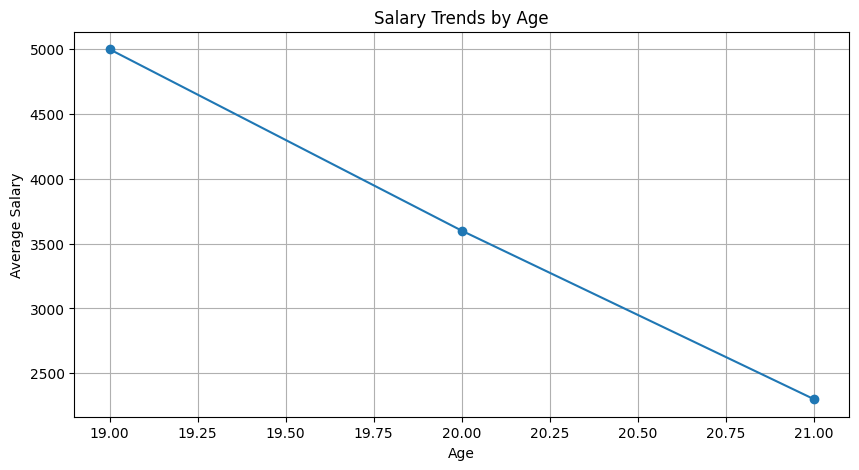

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


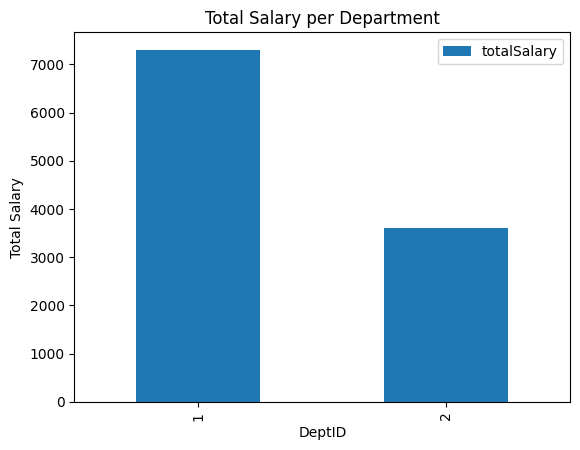

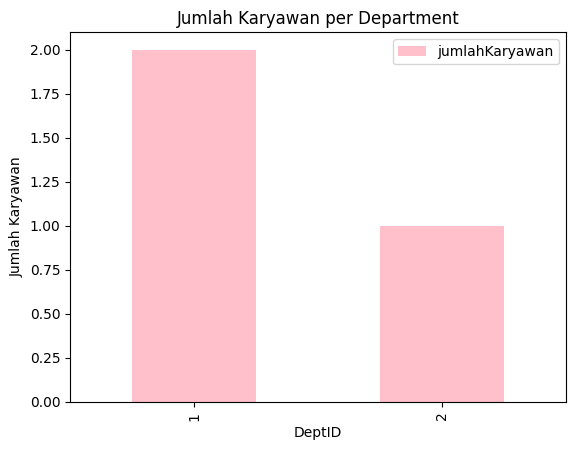

In [17]:
totalsalary_trends = spark.sql('''
SELECT DeptID, SUM(Salary) as totalSalary
FROM employees
GROUP BY DeptID
''').toPandas()

jumlahkaryawan_trends = spark.sql('''
SELECT DeptID, COUNT(*) as jumlahKaryawan
FROM employees
GROUP BY DeptID
''').toPandas()

totalsalary_trends.plot(x='DeptID', y='totalSalary', kind='bar')
plt.xlabel('DeptID')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')

jumlahkaryawan_trends.plot(x='DeptID', y='jumlahKaryawan', kind='bar', color='pink')
plt.xlabel('DeptID')
plt.ylabel('Jumlah Karyawan')
plt.title('Jumlah Karyawan per Department')
plt.show()

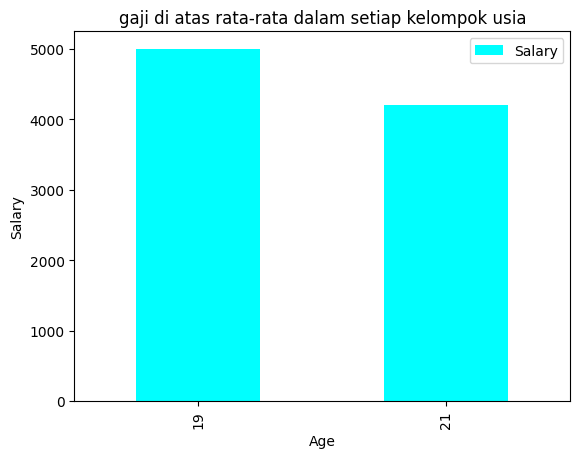

In [27]:
AboveAVGSalary = spark.sql('''
WITH avg_salary_per_age_group AS (
    SELECT Age, AVG(Salary) AS avgSalary
    FROM employees
    GROUP BY Age
)
SELECT e.Name, e.Age, e.Salary, a.avgSalary
FROM employees e
JOIN avg_salary_per_age_group a ON e.Age = a.Age
WHERE e.Salary > a.avgSalary
ORDER BY e.Age
''').toPandas()

AboveAVGSalary.plot(x='Age', y='Salary', kind='bar', color='cyan')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('gaji di atas rata-rata dalam setiap kelompok usia')
plt.show()